# Estimation de la consommation par habitant

In [97]:
import os
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import math
import random
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import sklearn.linear_model as linear_model
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.cluster import KMeans 

In [98]:
BASE_DIR ='C:/Users/d/Desktop/Programme du projet sur CNN pauvreté/'
RANDOM_SEED = 7 # for reproducibility
COUNTRIES_DIR = os.path.join(BASE_DIR, 'Data', 'countries')
RESULTS_DIR = os.path.join(BASE_DIR, 'results')
FIGURES_DIR = os.path.join(BASE_DIR, 'figures')

#### Fonction pour fusionner deux DataFrames sur la latitude et la longitude

def merge_on_lat_lon(df1, df2, keys=['cluster_lat', 'cluster_lon'], how='inner'): a pour but de Fusionner deux DataFrames df1 et df2 sur des colonnes spécifiques qui représentent des coordonnées géographiques (latitude et longitude).
La fusion basée sur des valeurs flottantes (comme les coordonnées géographiques) peut conduire à des imprécisions dues à la représentation en virgule flottante. Ce script contourne le problème en convertissant ces valeurs flottantes en entiers avant la fusion.
Les colonnes de latitude et longitude (keys) sont multipliées par 10000 et converties en entiers. Cette opération vise à préserver la précision tout en évitant les erreurs liées aux opérations sur les flottants.
Les colonnes originales de latitude et longitude sont supprimées dans df2 pour éviter les doublons après la fusion.
Une fusion (pd.merge) est effectuée sur les nouvelles colonnes entières avec l'option how permettant de spécifier le type de jointure (par défaut inner).
Les colonnes temporaires utilisées pour la fusion sont supprimées avant de retourner le DataFrame fusionné.

In [99]:
def merge_on_lat_lon(df1, df2, keys=['cluster_lat', 'cluster_lon'], how='inner'):
    """
    Fusionne deux DataFrames sur les colonnes de latitude et longitude.
    Nécessaire car la fusion directe sur des nombres flottants peut introduire des erreurs dues à la précision.
    """
    # Crée des copies des DataFrames pour éviter de modifier les originaux
    df1 = df1.copy()
    df2 = df2.copy()
    
    # Convertit les valeurs de latitude et longitude en entiers en multipliant par 10000
    # pour éviter les problèmes de précision avec les nombres flottants
    df1['merge_lat'] = (10000 * df1[keys[0]]).astype(int)
    df1['merge_lon'] = (10000 * df1[keys[1]]).astype(int)
    
    df2['merge_lat'] = (10000 * df2[keys[0]]).astype(int)
    df2['merge_lon'] = (10000 * df2[keys[1]]).astype(int)
    
    # Supprime les colonnes originales de latitude et longitude de df2 pour éviter les doublons
    df2.drop(keys, axis=1, inplace=True)
    
    # Fusionne les DataFrames sur les colonnes d'entiers de latitude et longitude
    merged = pd.merge(df1, df2, on=['merge_lat', 'merge_lon'], how=how)
    
    # Supprime les colonnes de fusion temporaires
    merged.drop(['merge_lat', 'merge_lon'], axis=1, inplace=True)
    
    return merged

#### Fonction pour assigner des groupes (clusters) à partir des coordonnées

def assign_groups(df, k, random_seed=7): a pour but d'assigner les points dans df (représentés par les colonnes cluster_lat, cluster_lon) à k groupes (ou clusters) en utilisant l'algorithme K-Means.
Un seed aléatoire est fixé pour garantir la reproductibilité des résultats.
L'algorithme K-Means est initialisé avec k centres et appliqué aux coordonnées de cluster.
La fonction retourne les étiquettes de cluster pour chaque point et les centres des clusters identifiés.

In [100]:
def assign_groups(df, k, random_seed=7):
    """
    Attribue les points dans df (colonnes cluster_lat, cluster_lon) à k groupes (clusters)
    en utilisant l'algorithme K-Means, et retourne également les centres des clusters.
    """
    # Fixe la graine aléatoire pour la reproductibilité
    np.random.seed(random_seed)
    
    # Initialise KMeans avec k clusters et applique l'algorithme sur les coordonnées
    km = KMeans(k)
    cluster_labels, cluster_centers = km.fit_predict(df[['cluster_lat', 'cluster_lon']]), km.cluster_centers_
    
    return cluster_labels, cluster_centers


#### Fonction pour exécuter une validation croisée randomisée

def run_randomized_cv(X, y, k=5, k_inner=5, random_seed=7, points=10, alpha_low=1, alpha_high=5, to_print=False):
a pour but d'exécuter une validation croisée randomisée sur les ensembles de données X et y, typiquement pour évaluer la performance d'un modèle de régression.
-Initialise un seed aléatoire pour la reproductibilité.
-Génère une grille d'hyperparamètres alphas logarithmiquement espacés entre alpha_low et alpha_high.
-Divise les données en k folds pour la validation croisée externe, et potentiellement en k_inner folds pour une validation croisée interne (non montrée dans le snippet).
-Pour chaque fold externe, sélectionne le meilleur hyperparamètre basé sur la performance dans la validation croisée interne, puis évalue ce modèle sur le fold de test externe.
-Agrège et retourne la performance moyenne (R²) et les prédictions (y_hat).

In [101]:

def run_randomized_cv(X, y, k=5, k_inner=5, random_seed=7, points=10, alpha_low=1, alpha_high=5, to_print=False):
    """
    Exécute une validation croisée randomisée sur X et y.
    Retourne le coefficient de détermination R² moyen et les prédictions y_hat.
    """
    # Fixe la graine aléatoire pour la reproductibilité
    np.random.seed(random_seed)
    
    # Génère une séquence logarithmique d'alphas entre alpha_low et alpha_high
    alphas = np.logspace(alpha_low, alpha_high, points)
    
    r2s = []  # Liste pour stocker les scores R² de chaque fold
    y_hat = np.zeros_like(y)  # Initialise un tableau pour les prédictions
    
    # Initialise KFold pour la division des données
    kf = KFold(n_splits=k, shuffle=True)
    
    fold = 0  # Compteur de fold
    for train_idx, test_idx in kf.split(X):
        # Évalue chaque fold et récupère le score R² et les prédictions
        r2, y_p = evaluate_fold(X, y, train_idx, test_idx, k_inner, alphas, to_print)
        r2s.append(r2)
        y_hat[test_idx] = y_p
        fold += 1
    
    # Calcule et retourne le R² moyen et les prédictions complètes
    return np.mean(r2s), y_hat


##### Fonction pour mettre à l'échelle les caractéristiques (features) des ensembles de données d'entraînement (X_train) et de test (X_test)

    def scale_features(X_train, X_test)  
    Cette fonction a pour but de mettre à l'échelle les caractéristiques (features) des ensembles de données d'entraînement (X_train) et de test (X_test) en utilisant la méthode de standardisation. Elle utilise la classe StandardScaler de la bibliothèque scikit-learn, qui est souvent utilisée en prétraitement des données pour les algorithmes de machine learning.  

- Initialisation de StandardScaler : L'instance de StandardScaler est initialisée avec les paramètres with_mean=True et with_std=False. Cela signifie que la fonction va centrer les données en soustrayant la moyenne de chaque caractéristique, mais elle ne va pas diviser par l'écart-type (puisque with_std=False). En d'autres termes, elle déplace le centre de distribution de chaque caractéristique à 0, mais ne normalise pas l'échelle de dispersion des données.

- Ajustement et transformation de l'ensemble d'entraînement (X_train) : La méthode fit_transform ajuste le scaler sur les données d'entraînement en calculant la moyenne de chaque caractéristique. Ensuite, elle transforme ces données en soustrayant la moyenne calculée, ce qui centre les données d'entraînement.

- Transformation de l'ensemble de test (X_test) : La méthode transform utilise le scaler déjà ajusté sur les données d'entraînement pour transformer les données de test. Cela garantit que les transformations appliquées sur les deux ensembles sont cohérentes, permettant ainsi aux modèles de machine learning de mieux généraliser à partir des données d'entraînement vers les données de test.

    Le but principal de cette fonction est donc de préparer les données pour les algorithmes de machine learning en assurant que les caractéristiques sont centrées autour de zéro, facilitant ainsi la convergence des algorithmes d'optimisation et améliorant potentiellement la performance des modèles. Cependant, en choisissant de ne pas normaliser la dispersion (with_std=False), cette fonction spécifique fait un choix non standard qui pourrait être motivé par des caractéristiques spécifiques des données ou des préférences de modélisation.  

In [102]:
def scale_features(X_train, X_test):
    """
    Met à l'échelle les caractéristiques en utilisant StandardScaler.
    """
    # Initialisation de StandardScaler pour centrer les données mais sans les réduire
    X_scaler = StandardScaler(with_mean=True, with_std=False)
    
    # Ajustement du scaler sur les données d'entraînement et transformation de ces données
    X_train = X_scaler.fit_transform(X_train)
    
    # Transformation des données de test basée sur le scaler ajusté à partir des données d'entraînement
    X_test = X_scaler.transform(X_test)
    
    return X_train, X_test

##### Fonction pour entrainer et predire ridge
    train_and_predict_ridge:  
- Objectif : Cette fonction est conçue pour entraîner un modèle de régression Ridge avec un ensemble de données d'entraînement (caractéristiques X_train et valeurs cibles y_train) et ensuite utiliser ce modèle pour faire des prédictions sur un ensemble de données de test (X_test).

- Modèle Ridge : La régression Ridge est une méthode de régression linéaire qui inclut une régularisation L2. La régularisation L2 est une technique utilisée pour réduire la complexité du modèle et prévenir le surapprentissage en ajoutant un terme de pénalité égal au carré de la magnitude des coefficients de régression au coût total de la régression. Le paramètre alpha contrôle l'intensité de cette pénalité : des valeurs plus élevées de alpha augmentent la force de la régularisation, ce qui peut empêcher le surapprentissage mais aussi rendre le modèle moins sensible aux données d'entraînement.

- Entraînement du modèle : La méthode fit est utilisée pour ajuster le modèle Ridge aux données d'entraînement, en trouvant les coefficients qui minimisent la fonction de coût régularisée.

- Prédiction : Après l'entraînement, le modèle utilise la méthode predict pour calculer les prédictions y_hat sur l'ensemble de test (X_test), en utilisant les coefficients appris lors de l'entraînement.

- Cette fonction est particulièrement utile dans les cas où la collinéarité entre les caractéristiques peut poser problème pour une régression linéaire ordinaire, ou pour prévenir le surapprentissage lorsque l'ensemble de données d'entraînement est très dimensionnel ou contient peu d'observations.

In [103]:
from sklearn import linear_model

def train_and_predict_ridge(alpha, X_train, y_train, X_test):
    """
    Entraîne un modèle Ridge et prédit les valeurs pour l'ensemble de test.

    Parameters:
    - alpha : Le paramètre de régularisation L2.
    - X_train : Les caractéristiques d'entraînement.
    - y_train : Les valeurs cibles d'entraînement.
    - X_test : Les caractéristiques de test pour lesquelles faire des prédictions.

    Returns:
    - y_hat : Les prédictions pour l'ensemble de test.
    """
    
    # Initialisation du modèle Ridge avec le paramètre de régularisation alpha
    ridge = linear_model.Ridge(alpha)
    
    # Entraînement du modèle Ridge sur l'ensemble d'entraînement
    ridge.fit(X_train, y_train)
    
    # Prédiction des valeurs cibles pour l'ensemble de test
    y_hat = ridge.predict(X_test)
    
    return y_hat


##### fonction pour trouver la meilleure valeur de l'hyperparamètre alpha 
- find_best_alpha:
- La fonction find_best_alpha est conçue pour trouver la meilleure valeur de l'hyperparamètre alpha pour un modèle de régression Ridge en utilisant une validation croisée entièrement randomisée. Cette approche aide à identifier le niveau optimal de régularisation L2 qui maximise la performance du modèle, typiquement mesurée ici par le coefficient de détermination R^2, dans le contexte de prédictions sur des données non vues pendant l'entraînement.
- Cette fonction parcourt différentes valeurs d'alpha fournies, effectue une validation croisée sur l'ensemble de données donné (X, y) en utilisant KFold pour diviser les données en un nombre spécifié de sous-ensembles (k_inner), entraîne un modèle Ridge sur chaque sous-ensemble d'entraînement, et évalue la performance du modèle sur chaque sous-ensemble de test correspondant. Elle utilise le score R^2, un indicateur de la qualité des prédictions du modèle (où une valeur plus proche de 1 signifie de meilleures prédictions), pour identifier la valeur d'alpha qui maximise la performance du modèle sur les données divisées. La fonction renvoie finalement la valeur d'alpha ayant donné le meilleur score R^2 

In [104]:
from sklearn.model_selection import KFold
from sklearn import metrics
import numpy as np

def scale_features(X_train, X_test):
    # Cette fonction doit être définie ailleurs, elle met à l'échelle les caractéristiques des ensembles d'entraînement et de test.
    pass

def train_and_predict_ridge(alpha, X_train, y_train, X_test):
    # Cette fonction doit également être définie ailleurs, elle entraîne un modèle Ridge et fait des prédictions sur l'ensemble de test.
    pass

def find_best_alpha(X, y, k_inner, alphas, to_print=False):
    """
    Trouve le meilleur alpha dans une boucle de validation croisée entièrement randomisée.
    
    Parameters:
    - X : les caractéristiques (features) de l'ensemble de données.
    - y : les valeurs cibles (target) de l'ensemble de données.
    - k_inner : le nombre de splits pour la validation croisée K-Fold.
    - alphas : une liste de valeurs alpha à tester.
    - to_print : si True, imprime le meilleur alpha trouvé.
    
    Returns:
    - best_alpha : la meilleure valeur de alpha trouvée.
    """
    # Initialisation du KFold pour la validation croisée
    kf = KFold(n_splits=k_inner, shuffle=True)
    best_alpha = 0
    best_r2 = 0
    
    # Itération sur chaque valeur de alpha
    for idx, alpha in enumerate(alphas):
        y_hat = np.zeros_like(y)  # Initialisation du tableau de prédictions
        
        # Boucle de validation croisée pour chaque split
        for train_idx, test_idx in kf.split(X):
            # Séparation des données en ensembles d'entraînement et de test
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            
            # Mise à l'échelle des caractéristiques
            X_train, X_test = scale_features(X_train, X_test)
            
            # Entraînement du modèle Ridge et prédiction sur l'ensemble de test
            y_hat[test_idx] = train_and_predict_ridge(alpha, X_train, y_train, X_test)
        
        # Calcul du score R2 pour les prédictions actuelles
        r2 = metrics.r2_score(y, y_hat)
        
        # Mise à jour du meilleur alpha si le score R2 actuel est meilleur
        if r2 > best_r2:
            best_alpha = alpha
            best_r2 = r2
            
    if to_print:
        print(f"Meilleur alpha : {best_alpha}, avec un score R^2 de : {best_r2}")
    
    return best_alpha


##### Fonction pour évaluer une division spécifique (un "fold") dans un processus de validation croisée externe.
    evaluate_fold  
- La fonction evaluate_fold est conçue pour évaluer une division spécifique (un "fold") dans un processus de validation croisée externe. La validation croisée externe est souvent utilisée pour évaluer la capacité de généralisation d'un modèle de machine learning en le testant sur plusieurs sous-ensembles de données qui n'ont pas été utilisés pendant l'entraînement. Cette approche est particulièrement utile pour estimer la performance d'un modèle de manière plus robuste et fiable.

    ##### Cette fonction effectue plusieurs étapes clés dans l'évaluation d'un modèle Ridge :    

- Séparation des données : Elle commence par diviser l'ensemble de données complet en sous-ensembles d'entraînement et de test basés sur les indices fournis.
- Optimisation d'hyperparamètres : Elle utilise une validation croisée interne (à travers la fonction find_best_alpha) sur l'ensemble d'entraînement pour trouver la valeur optimale de l'hyperparamètre alpha parmi ceux fournis. Cette étape permet d'ajuster le niveau de régularisation du modèle pour éviter le surapprentissage et améliorer sa capacité de généralisation.
- Prétraitement des caractéristiques : Avant l'entraînement du modèle, elle met à l'échelle les caractéristiques de l'ensemble d'entraînement et de test pour assurer que le modèle fonctionne de manière optimale.
- Entraînement et prédiction : Avec le meilleur alpha sélectionné, le modèle Ridge est entraîné sur l'ensemble d'entraînement, puis utilisé pour faire des prédictions sur l'ensemble de test.
- Évaluation du modèle : Finalement, la fonction évalue la performance du modèle sur l'ensemble de test en utilisant le score R^2, qui mesure la proportion de la variance pour la variable dépendante qui est prévisible à partir des variables indépendantes.
- En retournant le score R^2 et les prédictions pour l'ensemble de test, cette fonction fournit une mesure quantitative de la performance du modèle pour un fold spécifique de la validation croisée externe, permettant ainsi une évaluation approfondie de la capacité de généralisation du modèle.

In [105]:
def evaluate_fold(X, y, train_idx, test_idx, k_inner, alphas, to_print=False):
    """
    Évalue un fold de la validation croisée externe.

    Parameters:
    - X : les caractéristiques (features) de l'ensemble de données.
    - y : les valeurs cibles (target) de l'ensemble de données.
    - train_idx : indices des échantillons à utiliser comme ensemble d'entraînement pour le fold courant.
    - test_idx : indices des échantillons à utiliser comme ensemble de test pour le fold courant.
    - k_inner : le nombre de splits pour la validation croisée interne (utilisée pour sélectionner le meilleur alpha).
    - alphas : une liste de valeurs alpha à tester pour le modèle Ridge.
    - to_print : si True, imprime le meilleur alpha trouvé pendant la sélection.
    
    Returns:
    - r2 : le score R2 pour l'ensemble de test du fold courant.
    - y_test_hat : les prédictions pour l'ensemble de test du fold courant.
    """
    # Séparation des données en ensembles d'entraînement et de test selon les indices fournis
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Trouve le meilleur alpha en utilisant la validation croisée interne sur l'ensemble d'entraînement
    best_alpha = find_best_alpha(X_train, y_train, k_inner, alphas, to_print)

    # Mise à l'échelle des caractéristiques des ensembles d'entraînement et de test
    X_train, X_test = scale_features(X_train, X_test)

    # Entraînement du modèle Ridge avec le meilleur alpha trouvé et prédiction sur l'ensemble de test
    y_test_hat = train_and_predict_ridge(best_alpha, X_train, y_train, X_test)

    # Calcul du score R2 entre les valeurs prédites et les vraies valeurs de l'ensemble de test
    r2 = metrics.r2_score(y_test, y_test_hat)

    return r2, y_test_hat

In [6]:
pd.read_csv(os.path.join(BASE_DIR,'Data','Processed',"image_download_actual.csv"))
#pd.read_csv(os.path.join(BASE_DIR,'Data','Processed',"image_download_locs.csv"))

,image_name,image_lat,image_lon,cluster_lat,cluster_lon,pcexp,nightlights,nightlights_bin,is_train
0,5.4638471458443405_-4.05723036205941_5.4641465...,5.463847,-4.057230,5.464147,-4.056781,518465.0,181.0,1,True
1,5.46399686505836_-4.05723036205941_5.464146584...,5.463997,-4.057230,5.464147,-4.056781,518465.0,181.0,1,False
2,5.46414658427238_-4.05723036205941_5.464146584...,5.464147,-4.057230,5.464147,-4.056781,518465.0,181.0,1,True
3,5.4642963034864005_-4.05723036205941_5.4641465...,5.464296,-4.057230,5.464147,-4.056781,518465.0,181.0,1,True
4,5.46444602270042_-4.05723036205941_5.464146584...,5.464446,-4.057230,5.464147,-4.056781,518465.0,181.0,1,True
...,...,...,...,...,...,...,...,...,...
2929,6.859985734133001_-6.430992092734161_6.8598360...,6.859986,-6.430992,6.859836,-6.430842,611718.1,186.0,2,False
2930,6.86013545334702_-6.430992092734161_6.85983601...,6.860135,-6.430992,6.859836,-6.430842,611718.1,186.0,2,True
2931,6.86028517256104_-6.430992092734161_6.85983601...,6.860285,-6.430992,6.859836,-6.430842,611718.1,186.0,2,True
2932,6.85938685727692_-6.43084237352014_6.859836014...,6.859387,-6.430842,6.859836,-6.430842,611718.1,186.0,2,True


In [46]:
pd.read_csv(os.path.join(COUNTRIES_DIR, 'civ_2018', 'DataCIV.csv'))

,country,year,hhid,grappe,menage,vague,zae,region,milieu,milieu2,...,interview__key,interview__id,GPS__Latitude,GPS__Longitude,GPS__Accuracy,GPS__Altitude,GPS__Timestamp,nom_prenom_cm,localisation_menage,nightlights
0,CIV,2018,101.0,1,1,1,ABIDJAN,AUTONOME D'ABIDJAN,Urbain,Abidjan urbain,...,37-12-91-96,2eb3d29ba9814aa9bf99d6908559e7d2,5.340541,-4.026030,46.0,39.0,2018-10-29T17:56:23,NaN,NaN,175.0
1,CIV,2018,102.0,1,2,1,ABIDJAN,AUTONOME D'ABIDJAN,Urbain,Abidjan urbain,...,66-72-76-42,99990d719d6243a38fad96a4d7477742,5.340402,-4.025834,47.0,28.0,2018-10-29T17:54:35,NaN,NaN,0.0
2,CIV,2018,103.0,1,3,1,ABIDJAN,AUTONOME D'ABIDJAN,Urbain,Abidjan urbain,...,00-21-02-40,6cf633ef989c4a6a93ec483de1fd8193,5.340151,-4.025953,35.0,68.0,2018-10-29T17:51:50,NaN,NaN,0.0
3,CIV,2018,104.0,1,4,1,ABIDJAN,AUTONOME D'ABIDJAN,Urbain,Abidjan urbain,...,69-94-30-00,67feab4e35d141679ec4b867a59cba19,5.340500,-4.026202,32.0,59.0,2018-10-29T19:48:39,NaN,NaN,175.0
4,CIV,2018,105.0,1,5,1,ABIDJAN,AUTONOME D'ABIDJAN,Urbain,Abidjan urbain,...,92-17-10-43,dc1f1fa87d8e433e8891a4e55a8baca0,5.339820,-4.025066,49.0,72.0,2018-10-29T18:45:09,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12975,CIV,2019,108408.0,1084,8,2,CENTRE,MORONOU,Rural,Rural,...,50-03-51-41,103cff29baaf4405863e1043897aa6dc,6.546733,-4.508211,7.0,134.0,2019-06-16T19:42:05,NaN,NaN,0.0
12976,CIV,2019,108409.0,1084,9,2,CENTRE,MORONOU,Rural,Rural,...,82-42-90-66,e3a3deb8965e45c18018d1e5d103d914,6.549112,-4.505840,36.0,131.0,2019-06-17T08:10:57,NaN,NaN,0.0
12977,CIV,2019,108410.0,1084,10,2,CENTRE,MORONOU,Rural,Rural,...,21-28-94-39,45397589c6d44a478051e4089a884c97,6.551556,-4.507530,29.0,118.0,2019-06-16T09:30:14,NaN,NaN,0.0
12978,CIV,2019,108411.0,1084,11,2,CENTRE,MORONOU,Rural,Rural,...,24-86-66-78,505343592b0f4b8b8ede9980f714b8ab,6.552345,-4.507551,19.0,157.0,2019-06-16T10:18:13,NaN,NaN,0.0


In [49]:
import numpy as np
import os
import pandas as pd
import pickle
# Définition des chemins de base pour le projet
BASE_DIR = 'C:/Users/d/Desktop/Programme du projet sur CNN pauvreté/'
COUNTRIES_DIR = os.path.join(BASE_DIR, 'Data', 'countries')
RESULTS_DIR = os.path.join(BASE_DIR, 'results')
country_results_dir = os.path.join(RESULTS_DIR,'CIV_2018', 'cnn')
#df_clusters = pd.read_csv(os.path.join(BASE_DIR,'Data','Processed',"image_download_actual.csv"))
cluster_list1 = pickle.load(open(os.path.join(country_results_dir, 'cluster_order.pkl'), 'rb'))
cluster_list1 = pd.DataFrame.from_records(cluster_list1, columns=['cluster_lat', 'cluster_lon'])
cluster_list1['feat_index'] = np.arange(len(cluster_list1))
cluster_list1

,cluster_lat,cluster_lon,feat_index
0,5.315726,-4.256962,0
1,5.316201,-4.255147,1
2,5.316229,-4.256404,2
3,5.316659,-4.256400,3
4,5.316978,-4.255505,4
...,...,...,...
113,7.210943,-6.138940,113
114,7.211506,-6.140673,114
115,7.211531,-6.139787,115
116,7.211811,-6.139059,116


In [52]:
df_clusters_1=pd.read_csv(os.path.join(BASE_DIR,'Data','Processed',"image_download_actual.csv"))
df_clusters_1

,image_name,image_lat,image_lon,cluster_lat,cluster_lon,pcexp,nightlights,nightlights_bin,is_train
0,5.4638471458443405_-4.05723036205941_5.4641465...,5.463847,-4.057230,5.464147,-4.056781,518465.0,181.0,1,True
1,5.46399686505836_-4.05723036205941_5.464146584...,5.463997,-4.057230,5.464147,-4.056781,518465.0,181.0,1,False
2,5.46414658427238_-4.05723036205941_5.464146584...,5.464147,-4.057230,5.464147,-4.056781,518465.0,181.0,1,True
3,5.4642963034864005_-4.05723036205941_5.4641465...,5.464296,-4.057230,5.464147,-4.056781,518465.0,181.0,1,True
4,5.46444602270042_-4.05723036205941_5.464146584...,5.464446,-4.057230,5.464147,-4.056781,518465.0,181.0,1,True
...,...,...,...,...,...,...,...,...,...
2929,6.859985734133001_-6.430992092734161_6.8598360...,6.859986,-6.430992,6.859836,-6.430842,611718.1,186.0,2,False
2930,6.86013545334702_-6.430992092734161_6.85983601...,6.860135,-6.430992,6.859836,-6.430842,611718.1,186.0,2,True
2931,6.86028517256104_-6.430992092734161_6.85983601...,6.860285,-6.430992,6.859836,-6.430842,611718.1,186.0,2,True
2932,6.85938685727692_-6.43084237352014_6.859836014...,6.859387,-6.430842,6.859836,-6.430842,611718.1,186.0,2,True


In [53]:
df_clusters_2=pd.merge(df_clusters_1, cluster_list1, on=['cluster_lat', 'cluster_lon'])
df_clusters_2

,image_name,image_lat,image_lon,cluster_lat,cluster_lon,pcexp,nightlights,nightlights_bin,is_train,feat_index
0,5.4638471458443405_-4.05723036205941_5.4641465...,5.463847,-4.057230,5.464147,-4.056781,518465.0,181.0,1,True,36
1,5.46399686505836_-4.05723036205941_5.464146584...,5.463997,-4.057230,5.464147,-4.056781,518465.0,181.0,1,False,36
2,5.46414658427238_-4.05723036205941_5.464146584...,5.464147,-4.057230,5.464147,-4.056781,518465.0,181.0,1,True,36
3,5.4642963034864005_-4.05723036205941_5.4641465...,5.464296,-4.057230,5.464147,-4.056781,518465.0,181.0,1,True,36
4,5.46444602270042_-4.05723036205941_5.464146584...,5.464446,-4.057230,5.464147,-4.056781,518465.0,181.0,1,True,36
...,...,...,...,...,...,...,...,...,...,...
2929,6.859985734133001_-6.430992092734161_6.8598360...,6.859986,-6.430992,6.859836,-6.430842,611718.1,186.0,2,False,57
2930,6.86013545334702_-6.430992092734161_6.85983601...,6.860135,-6.430992,6.859836,-6.430842,611718.1,186.0,2,True,57
2931,6.86028517256104_-6.430992092734161_6.85983601...,6.860285,-6.430992,6.859836,-6.430842,611718.1,186.0,2,True,57
2932,6.85938685727692_-6.43084237352014_6.859836014...,6.859387,-6.430842,6.859836,-6.430842,611718.1,186.0,2,True,57


In [59]:
# Columns to be removed
columns_to_remove = ["image_name", "image_lat", "image_lon", "nightlights_bin", "is_train", "feat_index"]

# Remove specified columns
df_clusters_2_reduced = df_clusters_2.drop(columns=columns_to_remove)

# Group by "cluster_lat" and "cluster_lon", calculate the mean of "nightlights", and keep the mean of "pcexp"
df_clusters_3 = df_clusters_2_reduced.groupby(['cluster_lat', 'cluster_lon'], as_index=False).agg({'pcexp':'mean', 'nightlights':'mean'})
df_clusters_3

,cluster_lat,cluster_lon,pcexp,nightlights
0,5.315726,-4.256962,480084.00,0.0
1,5.316201,-4.255147,946489.90,0.0
2,5.316229,-4.256404,476108.50,0.0
3,5.316659,-4.256400,457755.53,0.0
4,5.316978,-4.255505,649427.20,0.0
...,...,...,...,...
113,7.210943,-6.138940,814531.25,185.0
114,7.211506,-6.140673,313424.10,185.0
115,7.211531,-6.139787,143521.69,185.0
116,7.211811,-6.139059,251916.52,0.0


In [60]:
# save the new dataframe to a CSV file
output_file_path = os.path.join(BASE_DIR, 'Data', 'Processed', 'clusters.csv') # Update this path to where you want to save the output
df_clusters_3.to_csv(output_file_path, index=False)

In [54]:
# Construction du chemin
#file_path = os.path.join(BASE_DIR, 'Data', 'Processed', 'clusters.csv')

# Save the DataFrame to a CSV file
#df_clusters_2.to_csv(file_path, index=False)

In [ ]:
# Fusion des DataFrames sur 'cluster_lat' et 'cluster_lon'
#df_clusters_2 = pd.merge(df_clusters_1, cluster_list1, on=['cluster_lat', 'cluster_lon'])

# Tri de df_clusters2 selon 'feat_index'
#df_clusters2 = df_clusters2.sort_values(by='feat_index')

# Affichage du résultat
#print(df_clusters2)

In [66]:
import numpy as np
import os
import pandas as pd
import pickle
# Définition des chemins de base pour le projet
BASE_DIR = 'C:/Users/d/Desktop/Programme du projet sur CNN pauvreté/'
COUNTRIES_DIR = os.path.join(BASE_DIR, 'Data', 'countries')
RESULTS_DIR = os.path.join(BASE_DIR, 'results')

def load_country(country):
    '''
    Organizes the country's dataframe so that each index corresponds to the index in the cluster features.
    Returns the cluster features and the organized dataframe.
    
    Parameters:
    country (str): The country and year identifier.
    
    Returns:
    numpy.ndarray: The cluster features loaded from 'cluster_feats.npy'.
    pandas.DataFrame: The organized DataFrame with cluster information and feature indices.
    '''
    # Définition des chemins spécifiques pour les données traitées et les résultats du pays
    country_processed_dir = os.path.join(COUNTRIES_DIR, country)
    country_results_dir = os.path.join(RESULTS_DIR,'CIV_2018', 'cnn')
    
    # Chargement des caractéristiques des clusters
    x = np.load(os.path.join(country_results_dir, 'cluster_feats.npy'))
    
    # Chargement et transformation de la liste des clusters en DataFrame
    cluster_list = pickle.load(open(os.path.join(country_results_dir, 'cluster_order.pkl'), 'rb'))
    cluster_list = pd.DataFrame.from_records(cluster_list, columns=['cluster_lat', 'cluster_lon'])
    cluster_list['feat_index'] = np.arange(len(cluster_list))
    
    # Chargement du DataFrame des clusters à partir du fichier "image_download_actual.csv"
    #df_clusters = pd.read_csv(os.path.join(country_processed_dir, 'DataCIV.csv'))
    df_clusters= pd.read_csv(os.path.join(BASE_DIR,'Data','Processed',"clusters.csv"))
    assert len(df_clusters) == len(cluster_list)
    
    # Fusion des DataFrames sur les colonnes de latitude et de longitude des clusters
    #df = pd.merge(df_clusters, cluster_list, on=['cluster_lat', 'cluster_lon'], how='left')
    df = merge_on_lat_lon(df_clusters, cluster_list, keys=['cluster_lat', 'cluster_lon'])
    
    # Tri du DataFrame fusionné selon l'index des caractéristiques pour aligner avec l'ordre dans x
    df.sort_values('feat_index', ascending=True, inplace=True)
    
    return x, df


In [67]:
# Utilisation de la fonction pour charger les données spécifiques à la Côte d'Ivoire (CIV_2018)
x_civ, df_civ = load_country('civ_2018')

In [68]:
x_civ

array([[-0.32545972,  0.24763748, -0.09928537, ...,  0.89236591,
         0.35499989, -1.0022939 ],
       [-0.19864731,  0.253822  , -0.12479536, ...,  1.09822744,
         0.30112427, -1.26371315],
       [-0.28169438,  0.31361491, -0.17740343, ...,  1.20070942,
         0.24649373, -1.2806107 ],
       ...,
       [-0.10370591,  0.46759259,  0.2438687 , ...,  0.57140918,
         0.37366675, -0.79307973],
       [-0.52823968,  0.38486503, -0.16563675, ...,  0.70772919,
         0.31124413, -0.89975798],
       [-0.409882  ,  0.46132919, -0.16399848, ...,  0.61042985,
         0.4337463 , -0.87806427]])

In [69]:
df_civ

,cluster_lat,cluster_lon,pcexp,nightlights,feat_index
0,5.315726,-4.256962,480084.00,0.0,0
1,5.316201,-4.255147,946489.90,0.0,1
2,5.316229,-4.256404,476108.50,0.0,2
3,5.316659,-4.256400,457755.53,0.0,3
4,5.316978,-4.255505,649427.20,0.0,4
...,...,...,...,...,...
113,7.210943,-6.138940,814531.25,185.0,113
114,7.211506,-6.140673,313424.10,185.0,114
115,7.211531,-6.139787,143521.69,185.0,115
116,7.211811,-6.139059,251916.52,0.0,116


In [64]:
#len(pickle.load(open(os.path.join(os.path.join(os.path.join(BASE_DIR, 'results'), 'CIV_2018', 'cnn'), 'cluster_order.pkl'), 'rb')))
# Quand on exécute ce code on trouve 118

In [65]:
#Ce script charge et transforme des données de clustering sauvegardées depuis un fichier pickle en un DataFrame pandas,
#pickle.load(open(os.path.join(os.path.join(RESULTS_DIR, 'CIV_2018', 'cnn'), 'cluster_order.pkl'), 'rb')) :
#Cette partie du code utilise le module pickle pour charger (désérialiser) des données depuis un fichier.
#Le fichier est ouvert en mode binaire ('rb'), et son chemin est construit à l'aide de os.path.join.puis calcule la longueur (nombre de lignes) de ce DataFrame.
#len(pd.DataFrame.from_records(pickle.load(open(os.path.join(os.path.join(RESULTS_DIR, 'CIV_2018', 'cnn'), 'cluster_order.pkl'), 'rb')), columns=['cluster_lat', 'cluster_lon']))
#Quand on exécute ce code on trouve comme valeur 118

In [70]:
#pd.read_csv(os.path.join(COUNTRIES_DIR, 'civ_2018', 'DataCIV.csv'))

In [71]:
y_civ = df_civ['pcexp'].values

In [72]:
y_civ

array([ 480084.  ,  946489.9 ,  476108.5 ,  457755.53,  649427.2 ,
        602126.06, 1466982.2 ,  264990.47,  483992.4 , 1102975.1 ,
       1121626.  ,  503520.12,  699679.  ,  915827.3 ,  674080.4 ,
        910021.8 ,  303571.62,  485543.03,  378359.9 , 1072305.5 ,
       1542145.  ,  688071.44,  920880.  ,  668038.3 , 2403145.2 ,
       1610234.  ,  739434.3 , 1993093.2 , 1020748.94,  737665.6 ,
        336827.12, 1304856.4 ,  918720.44, 1357092.  , 1083334.  ,
       1020685.44,  518465.  , 1075906.1 ,  390902.38,  519539.03,
        607586.8 ,  730943.7 ,  510600.56,  514983.16,  592090.3 ,
        571890.56,  895821.9 ,  767802.94,  448018.03,  596766.2 ,
        512261.16,  436516.3 ,  896780.9 ,  507063.4 ,  959958.6 ,
        332252.12,  380996.47,  611718.1 ,  294176.25,  405037.4 ,
        461653.1 ,  428863.94,  534028.44,  260174.3 ,  461748.7 ,
        473441.22,  434971.4 , 1192741.1 ,  676296.44,  507652.3 ,
       1364959.8 , 1031343.25, 4774914.5 ,  904449.7 , 1796358

In [76]:
# Calcul de la corrélation de Pearson entre "pcexp" et "nightlights"
#correlation = df_civ['pcexp'].corr(df_civ['nightlights'])

#print(f"La corrélation entre pcexp et nightlights est de: {correlation}")
#La corrélation entre pcexp et nightlights est de: 0.04590079966057145


##### Fonction pour tester et comparer les performances de la validation croisée
    test_fully_randomized_cv  
- La fonction test_fully_randomized_cv est conçue pour tester et comparer les performances de la validation croisée entièrement aléatoire sur un ensemble de données en utilisant deux approches différentes pour traiter les valeurs cibles : une approche utilisant les valeurs cibles originales et une autre utilisant le logarithme des valeurs cibles.
- Cette fonction évalue l'efficacité de transformer ou non les valeurs cibles en leur logarithme avant de procéder à une validation croisée. L'utilisation du logarithme des valeurs cibles peut être particulièrement utile dans les cas où les données cibles sont très asymétriques ou lorsqu'il y a des valeurs extrêmes (outliers) qui peuvent biaiser l'apprentissage du modèle. La transformation log peut aider à normaliser la distribution des valeurs cibles, rendant potentiellement le modèle plus performant et plus stable.
- En affichant les scores R^2 pour les deux approches, cette fonction permet d'évaluer l'impact de la transformation log sur la performance du modèle, fournissant ainsi des insights précieux sur la meilleure manière de prétraiter les valeurs cibles pour cet ensemble de données spécifique.

In [106]:
def test_fully_randomized_cv():
    """
    Teste la validation croisée entièrement aléatoire sur un ensemble de données.
    
    Cette fonction exécute deux versions de validation croisée:
    1. En utilisant les valeurs cibles originales.
    2. En utilisant le logarithme des valeurs cibles.
    
    Elle affiche les scores R^2 pour chaque approche pour évaluer leur performance.
    """
    # Message initial indiquant le début du test
    print("Teste la validation croisée entièrement aléatoire CV:\n--------------\n")
    
    # Concaténation des données de caractéristiques et cibles pour obtenir un ensemble complet
    x_all = np.concatenate([x_civ], axis=0)
    y_all = np.concatenate([y_civ], axis=0)
    
    # Validation croisée avec les valeurs cibles originales
    r2_direct, _ = run_randomized_cv(x_all, y_all, random_seed=RANDOM_SEED, to_print=False)
    
    # Validation croisée avec le logarithme des valeurs cibles
    r2_log, _ = run_randomized_cv(x_all, np.log(y_all), random_seed=RANDOM_SEED)
    
    # Affichage des scores R^2 pour les deux approches
    print(f"Pour la validation croisée entièrement aléatoire cv: direct r2: {r2_direct}, log r2: {r2_log}")

In [126]:
import os
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import math
import random
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import sklearn.linear_model as linear_model
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.cluster import KMeans 
from sklearn import linear_model

def train_and_predict_ridge(alpha, X_train, y_train, X_test):
    """
    Entraîne un modèle Ridge et prédit les valeurs pour l'ensemble de test.
    """
    ridge = linear_model.Ridge(alpha)
    ridge.fit(X_train, y_train)
    y_hat = ridge.predict(X_test)
    return y_hat

def scale_features(X_train, X_test):
    """
    Met à l'échelle les caractéristiques en utilisant StandardScaler.
    """
    X_scaler = StandardScaler(with_mean=True, with_std=False)
    X_train = X_scaler.fit_transform(X_train)
    X_test = X_scaler.transform(X_test)
    return X_train, X_test

def find_best_alpha(X, y, k_inner, alphas, to_print=False):
    """
    Trouve le meilleur alpha dans une boucle de validation croisée entièrement randomisée.
    """
    kf = KFold(n_splits=k_inner, shuffle=True)
    best_alpha = 0
    best_r2 = 0
    for idx, alpha in enumerate(alphas):
        y_hat = np.zeros_like(y)
        for train_idx, test_idx in kf.split(X):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            X_train, X_test = scale_features(X_train, X_test)
            y_hat[test_idx] = train_and_predict_ridge(alpha, X_train, y_train, X_test)
        r2 = metrics.r2_score(y, y_hat)
        if r2 > best_r2:
            best_alpha = alpha
            best_r2 = r2
    if to_print:
        print(f"Meilleur alpha : {best_alpha}, avec un score R^2 de : {best_r2}")
    return best_alpha

def evaluate_fold(X, y, train_idx, test_idx, k_inner, alphas, to_print=False):
    """
    Évalue un fold de la validation croisée externe.
    """
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    best_alpha = find_best_alpha(X_train, y_train, k_inner, alphas, to_print)
    X_train, X_test = scale_features(X_train, X_test)
    y_test_hat = train_and_predict_ridge(best_alpha, X_train, y_train, X_test)
    r2 = metrics.r2_score(y_test, y_test_hat)
    return r2, y_test_hat

def run_randomized_cv(X, y, k=5, k_inner=5, random_seed=7, points=10, alpha_low=1, alpha_high=100, to_print=False):
    """
    Exécute une validation croisée randomisée sur X et y.
    """
    np.random.seed(random_seed)
    alphas = np.logspace(np.log10(alpha_low), np.log10(alpha_high), points)
    r2s = []
    y_hat = np.zeros_like(y)
    kf = KFold(n_splits=k, shuffle=True)
    for train_idx, test_idx in kf.split(X):
        r2, y_p = evaluate_fold(X, y, train_idx, test_idx, k_inner, alphas, to_print)
        r2s.append(r2)
        y_hat[test_idx] = y_p
    return np.mean(r2s), y_hat


In [127]:
# Appel de la fonction pour exécuter le test
test_fully_randomized_cv()

Teste la validation croisée entièrement aléatoire CV:
--------------

Pour la validation croisée entièrement aléatoire cv: direct r2: -0.05641987073356476, log r2: -0.1204694729657165


### Les graphs

La fonction plot_predictions est conçue pour visualiser la corrélation entre les valeurs réelles et prédites d'un modèle de régression, tout en mettant en évidence le score R^2 pour évaluer la qualité de la prédiction. 

In [136]:
# Définition de la fonction avec des paramètres pour les valeurs réelles et prédites, le score R^2, le nom du pays pour le titre, et un seuil optionnel max_y pour filtrer les données.
def plot_predictions(y, yhat, r2, country, max_y=None):
    # Si un seuil max_y est fourni, filtre les données pour ne garder que celles où les valeurs réelles sont inférieures à ce seuil.
    if max_y is not None:
        yhat = yhat[y < max_y]
        y = y[y < max_y]
    
    # Crée une nouvelle figure pour le tracé avec une taille spécifiée.
    fig = plt.figure(figsize=(8,5))
    
    # Tracé des valeurs réelles par rapport aux valeurs prédites en tant que nuage de points pour visualiser la distribution et la corrélation.
    plt.scatter(y, yhat, alpha=0.6)
    
    # Calcul et tracé d'une ligne de tendance linéaire basée sur les valeurs réelles et prédites pour montrer la direction générale de la corrélation.
    plt.plot(np.unique(y), np.poly1d(np.polyfit(y, yhat, 1))(np.unique(y)), color='g')
    
    # Ajoute un texte sur le graphique pour afficher le score R^2, arrondi à deux décimales, indiquant la qualité du modèle de prédiction.
    plt.text(750000,750000 , f'r^2={round(r2, 2)}', size=12)
    
    # Définit l'étiquette de l'axe des abscisses.
    plt.xlabel('Consommation par tete(FrCFA/An)')
    
    # Définit l'étiquette de l'axe des ordonnées.
    plt.ylabel('Prediction de Consommation par tete(FrCFA/An)')
    
    # Ajoute un titre à la figure, incluant le nom du pays pour spécifier les résultats présentés.
    plt.title(f'{country} Resultats')
    
    # Retourne l'objet figure contenant le tracé pour une utilisation ou sauvegarde ultérieure.
    return fig


##### Visualisation de la performance du modèle
Ce script illustre une méthode efficace pour évaluer et visualiser la performance d'un modèle de régression sur un ensemble de données spécifique. 
En limitant l'analyse aux données avec des valeurs réelles en dessous d'un certain seuil (max_y=20), il permet une inspection plus ciblée des prédictions du modèle dans une plage de valeurs plus pertinentes ou plus fiables.
Le score r^2 affiché sur le graphique fournit une mesure quantitative de la performance du modèle, indiquant dans quelle mesure les prédictions correspondent aux valeurs réelles dans le contexte spécifique de la Cote d'Ivoire.

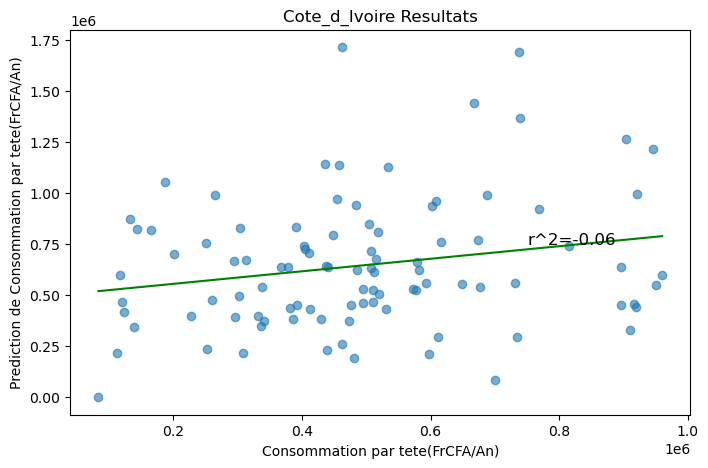

In [137]:
# Exécute la fonction run_randomized_cv pour la CIV en utilisant les données x_civ (features) et y_civ (valeurs cibles).
# Cette fonction applique une validation croisée randomisée pour évaluer la performance du modèle de régression de Ridge,
# en optimisant le paramètre alpha et en retournant le score R^2 moyen ainsi que les prédictions yhat_civ sur l'ensemble de test.
# RANDOM_SEED est utilisé pour assurer la reproductibilité des sélections aléatoires durant la validation croisée.
# to_print=False indique que la fonction ne doit pas imprimer les résultats intermédiaires pendant son exécution.
r2, yhat_civ = run_randomized_cv(x_civ, y_civ, random_seed=RANDOM_SEED, to_print=False)

# Utilise la fonction plot_predictions pour visualiser les prédictions (yhat_civ) par rapport aux valeurs réelles (y_civ) pour la Cote d'Ivoire.
# Le graphique montre la corrélation entre les consommations réelles et prédites en frcfa/an, avec un seuil max_y de 1000000.
# Cela signifie que seules les données où les valeurs réelles sont inférieures à 1000000 frcfa/an seront incluses dans le graphique.
# Le score R^2 (r2) obtenu de la validation croisée est affiché sur le graphique pour évaluer la qualité de l'ajustement du modèle.
# Le titre 'Résultats Cote d'Ivoire spécifie que les résultats concernent la Cote d'Ivoire, offrant un contexte clair pour l'analyse.
# L'objet fig retourné par la fonction peut être utilisé pour sauvegarder le graphique ou pour une analyse plus approfondie.
fig = plot_predictions(y_civ, yhat_civ, r2, 'Cote_d_Ivoire', max_y=1000000)
